In [1]:
%matplotlib inline

In [2]:
import os, sys, glob
from pathlib import Path

import numpy as np
from numpy import nan as NaN
import pandas as pd
import matplotlib.pyplot as plt 

import seaborn as sns
#import ptitprince as pt

In [3]:
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
print('seaborn version: ', sns.__version__)

numpy version:  1.21.5
pandas version:  1.3.5
matplotlib version:  2.2.5
seaborn version:  0.11.2


# Fixation Compliance

This notebook includes code used to generate figures to assess fixation compliance during image viewing.

It generates the following figure from the datapaper:

* **Fig 2B**, gaze position in relation to screen center, in degrees of visual angle, during image presentation (downsampled to 50Hz). Contours represent 25, 50 and 75% of the gaze density. 
* **Fig 2B insert**, the cumulative gaze distribution as a function of the distance to the screen center, in degrees of visual angles (vertical lines indicate 1-5 degrees, horizontal line is 100%).

To run the cells, you will need to **pull the following input files**: 
* ***cneuromod-things/THINGS/behaviour/sub-{s}/fix/sub-{s}_task-things_desc-driftCor_gaze.tsv***


In [4]:
"""
Support functions and parameters
"""


"""
This script registers the "turbo" colormap to matplotlib
and the reversed version as "turbo_r"

Reference:  https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html

Created on 2019-08-22 09:37:36
@author: fmiorell

source: https://gist.github.com/FedeMiorelli/640bbc66b2038a14802729e609abfe89

"""
turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])


def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


mpl_data = RGBToPyCmap(turbo_colormap_data)
plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])



"""
Gaussian function from PyGazeAnalyser's gazeplotter.py script

source:
https://github.com/esdalmaijer/PyGazeAnalyser/blob/de44913fb60876134c5b942690d586e5dab40476/pygazeanalyser/gazeplotter.py#L423
"""

def gaussian(x, sx, y=None, sy=None):
    """Returns an array of numpy arrays (a matrix) containing values between
    1 and 0 in a 2D Gaussian distribution
    
    arguments
    x : width in pixels
    sx: width standard deviation
    
    keyword arguments
    y: height in pixels (default = x)
    sx: heigh standard deviation (default = sx)
    """
    
    # square Gaussian if only x values are passed
    if y == None:
        y = x  
    if sy == None:
        sy = sx
        
    # centers
    xo = x/2
    yo = y/2
    # matrix of zeros
    M = np.zeros([y,x],dtype=float)
    # gaussian matrix
    for i in range(x):
        for j in range(y):
            
            M[j,i] = np.exp(-1.0 * (((float(i)-xo)**2/(2*sx*sx)) + ((float(j)-yo)**2/(2*sy*sy)) ) )
    
    return M



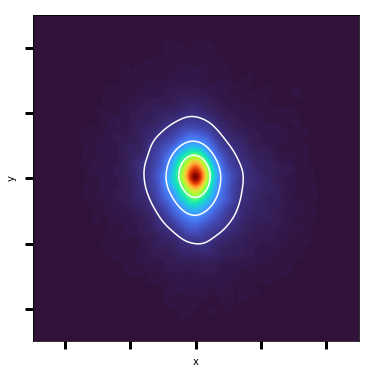

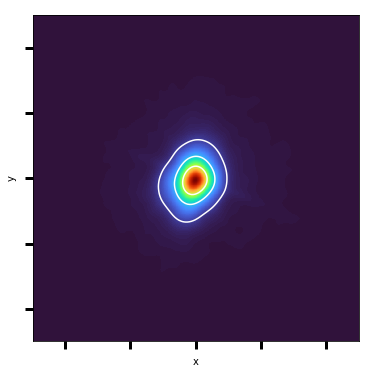

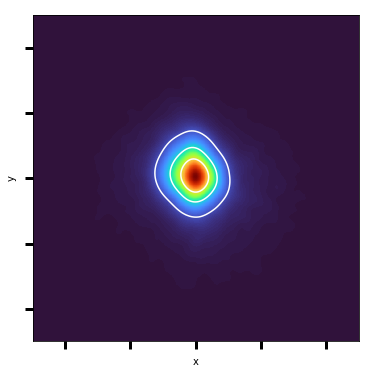

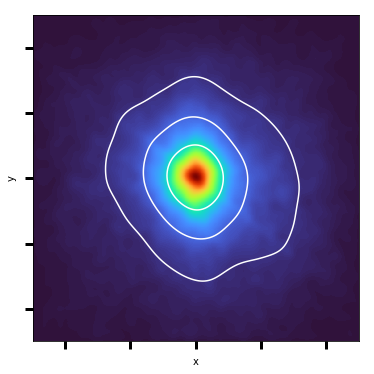

In [5]:
"""
Generate heatmap figures with or without white contours
"""

# set to True to export .png file
save_fig = False

# set to True to add contour lines to figure
add_contour = True

fix_file_path = Path("../../THINGS/behaviour").resolve()
fig_save_path = Path("../figures").resolve()

for s_num in ["01", "02", "03", "06"]:
    
    # Load gaze position data
    df_et = pd.read_csv(
        f"{fix_file_path}/sub-{s_num}/fix/sub-{s_num}_"
        "task-things_desc-driftCor_gaze.tsv",
        sep = '\t'
    )

    # filter gaze outside window (-5 to 5 degrees
    # from central fixation in x and y)
    df_fig = df_et[np.logical_and(
        df_et["x"].to_numpy() > -5.0,
        df_et["x"].to_numpy() < 5.0
    )]
    df_fig = df_fig[np.logical_and(
        df_fig["y"].to_numpy() > -5.0,
        df_fig["y"].to_numpy() < 5.0
    )]
    
    # Create heatmap
    # Convert gaze coordinates from degrees to pixels
    x_pix = ((df_fig["x"].to_numpy()+5.0)*(1280/17.5)).astype(int)
    y_pix = ((df_fig["y"].to_numpy()+5.0)*(1024/14.0)).astype(int)
    screen_dim = (int(1280*(10.0/17.5)), int(1024*(10.0/14.0)))

    gwh = 50
    gsdwh = gwh/6
    gaus = gaussian(gwh,gsdwh)
    strt = int(gwh/2)

    heatmapsize = int(screen_dim[1] + 2*strt), int(screen_dim[0] + 2*strt)
    heatmap = np.zeros(heatmapsize, dtype=float)

    # add Gaussian to the current heatmap
    for i in range(len(x_pix)):
        x = int(x_pix[i])
        y = int(y_pix[i])
        heatmap[y:y+gwh,x:x+gwh] += gaus

    # resize heatmap (trim added padding)
    heatmap = heatmap[strt:screen_dim[1]+strt,strt:screen_dim[0]+strt]

    # normalize heatmap values between 0 and 1
    min_val = np.min(heatmap)
    heatmap -= min_val
    max_val = np.max(heatmap)
    heatmap = heatmap/max_val    
    
    
    plt.figure(figsize=(6,6))
    plt.imshow(heatmap, cmap='turbo', alpha=1.0)
    
    
    # Add contours to heatmap
    if add_contour:
        # convert degrees of visual angle into pixel coordinates
        x_pix_val = (df_fig["x"].to_numpy()+5.0)*(1280/17.5)
        y_pix_val = (df_fig["y"].to_numpy()+5.0)*(1024/14.0)

        # make dataframe of gaze in pixels for seaborn
        gaze_df = pd.DataFrame({
            "x": x_pix_val,
            "y": y_pix_val,
        })
        
        sns.kdeplot(
            data=gaze_df,
            x="x",
            y="y",
            color="xkcd:white",
            bw_adjust=2,
            levels=[0.25, 0.5, 0.75]
        ) #levels=(0.75, 0.90))#, levels=2)

    #plt.xticks(np.arange(73, 730, int(731/5)), [-4, -2, 0, 2, 4])
    #plt.yticks(np.arange(73, 730, int(731/5)), [-4, -2, 0, 2, 4])
    plt.xticks(np.arange(73, 730, int(731/5)), ["", "", "", "", ""])
    plt.yticks(np.arange(73, 730, int(731/5)), ["", "", "", "", ""])

    plt.xlim([0, 731])
    plt.ylim([0, 731])

    ax = plt.gca()
    ax.tick_params(width=3, size=8)

    if save_fig:
        plt.savefig(f'{fig_save_path}/sub-{s_num}_eyetrack_heatmap.jpg', dpi=300) 

    plt.show()


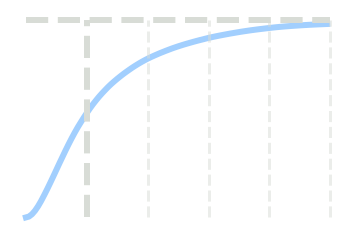

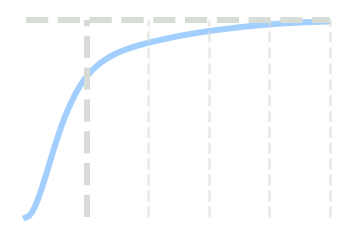

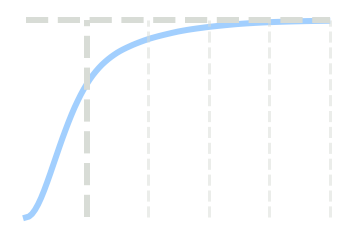

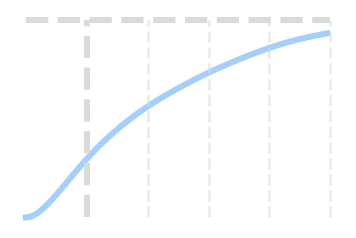

In [6]:
# set to True to export .png file
save_fig = False

for s_num in ["01", "02", "03", "06"]:
    
    # Load gaze position data
    df_et = pd.read_csv(
        f"{fix_file_path}/sub-{s_num}/fix/sub-{s_num}_"
        "task-things_desc-driftCor_gaze.tsv",
        sep = '\t'
    )


    indices = np.argsort(df_et["dist"].to_numpy())

    idx_90 = int(0.9*df_et.shape[0])
    idx_75 = int(0.75*df_et.shape[0])

    df_sortdist = df_et["dist"].to_numpy()[indices]
    df_sortx = df_et["x"].to_numpy()[indices]
    df_sorty = df_et["y"].to_numpy()[indices]

    x = []
    y = []

    total = df_sortdist.shape[0]

    for i in range(0, 100, 1):
        cutoff = 5.0*(i/100)
        x.append(cutoff)    
        y.append(np.sum(df_sortdist < cutoff)/total)


    plt.box(False)

    plt.plot(x, y, color="xkcd:baby blue", linewidth=6)    
    plt.plot([0.0, 5.0], [1.0, 1.0], linestyle='dashed', linewidth=6, color="xkcd:light grey")
    plt.plot([1.0, 1.0], [0.0, 1.0], linestyle='dashed', linewidth=6, color="xkcd:light grey")
    plt.plot([2.0, 2.0], [0.0, 1.0], linestyle='dashed', linewidth=3, color="xkcd:light grey", alpha=0.5)
    plt.plot([3.0, 3.0], [0.0, 1.0], linestyle='dashed', linewidth=3, color="xkcd:light grey", alpha=0.5)
    plt.plot([4.0, 4.0], [0.0, 1.0], linestyle='dashed', linewidth=3, color="xkcd:light grey", alpha=0.5)
    plt.plot([5.0, 5.0], [0.0, 1.0], linestyle='dashed', linewidth=3, color="xkcd:light grey", alpha=0.5)

    plt.xticks([], [])
    plt.yticks([], [])

    if save_fig:
        plt.savefig(f'{fig_save_path}/sub-{s_num}_cummul_gaze.png', transparent=True, dpi=300) 

    plt.show()
